## Preprocessing Text

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
emails = glob('emails/*')
emails[:5]

['emails\\00001',
 'emails\\00002',
 'emails\\00003',
 'emails\\00004',
 'emails\\00005']

In [3]:
with open(emails[0], 'r') as f:
    em1 = ' '.join(f.readlines())

print(em1)

Subject: XV under MS-DOS ?!?
 From: NO E-MAIL ADDRESS@eicn.etna.ch
 Organization: EICN, Switzerland
 Lines: 24
 
 Hi ... Recently I found XV for MS-DOS in a subdirectory of GNU-CC (GNUISH). I 
 use frequently XV on a Sun Spark Station 1 and I never had problems, but when I
 start it on my computer with -h option, it display the help menu and when I
 start it with a GIF-File my Hard disk turns 2 or 3 seconds and the prompt come
 back.
 
 My computer is a little 386/25 with copro, 4 Mega rams, Tseng 4000 (1M) running
 MS-DOS 5.0 with HIMEM.SYS and no EMM386.SYS. I had the GO32.EXE too... but no
 driver who run with it.
 
 Do somenone know the solution to run XV ??? any help would be apprecied..
 		
 	Thanx in advance !!!! 
              
 -- 
 ---------------------------------------------------------------------
 *								    *
 *  Pascal PERRET     		|	perret@eicn.etna.ch         *
 *  Ecole d'ingénieur ETS	|	(Not Available at this time)*
 *  2400 Le LOCLE		|				    *
 *  Suisse 							

In [4]:
with open(emails[1], 'r') as f:
    em2 = ' '.join(f.readlines())
    
print(em2)

From: mark@ocsmd.ocs.com (Mark Wilson)
 Subject: Re: TIFF: philosophical significance of 42 (SILLY)
 Organization: Online Computer Systems, Inc.
 X-Newsreader: Tin 1.1 PL5
 Lines: 20
 
 Mark A. Cartwright (markc@emx.utexas.edu) wrote:
 : Well,
 : 
 : 42 is 101010 binary, and who would forget that its the
 : answer to the Question of "Life, the Universe, and Everything else."
 : That is to quote Douglas Adams in a round about way.
 : 
 : Of course the Question has not yet been discovered...
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 But it WAS discovered (sort of).  The question was "What is 7 times 8?"
 When Arthur Dent objected that this was, unfortunately, factually
 inaccurate, the effort to discover the question was begun all over.
 This last effort was, I believe, likely to take far longer than
 the lifespan of the universe, in fact several lifespans of same!
 --
 -------------------------------------------------------------------------------
 Mark Wilson, Online C

In [ ]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('omw-1.4')

In [120]:
def preprocess(text):
    text_p = re.sub(r'\S+[@./]\S+', '', text) # get rid of emails / links
    text_p = re.sub(r'\s\S\s', ' ', text_p)
    text_p = word_tokenize(text_p)
    text_p = [t for t in text_p if re.match('[^\d\W]', t) ]
    text_p = [t for t in text_p if t.lower() not in ['subject', 'e-mail', 'address', 'organization', 'lines']]
    text_p = [w.lower() for w in text_p if not w.lower() in stop_words]

    text_p = [lemmatizer.lemmatize(w) for w in text_p]

#     tagged = {w:t for w, t in nltk.pos_tag(text_p)}
#     text_p = [w for w in text_p if tagged[w][0]=='N']
    
#     text_p = [ps.stem(w) for w in text_p]
    return ' '.join(text_p)

print(preprocess(em1))

xv ms-dos eicn switzerland hi recently found xv ms-dos subdirectory gnu-cc gnuish use frequently xv sun spark station never problem start computer option display help menu start gif-file hard disk turn second prompt come back computer little copro mega ram tseng running ms-dos driver run somenone know solution run xv help would thanx advance pascal perret ecole d'ingénieur ets available time le locle suisse enjoy computer


In [122]:
corpus = []

for file in emails:
    with open(file, 'r') as f:
        corpus.append(preprocess(' '.join(f.readlines())) )

In [123]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=10, window=10, min_count=2, workers=4, dm=1)

In [124]:
vec = model.infer_vector(corpus[25].split())
model.wv.most_similar(positive=vec, topn=5)

[('paper-cutting', 0.982207179069519),
 ('stylish', 0.9747614860534668),
 ('ta-rw404', 0.9716848134994507),
 ('pricier', 0.9604130983352661),
 ('haynes', 0.9568780064582825)]

In [125]:
def closest_topic(model, vector, topn=5):
    return model.wv.most_similar(positive=vector, topn=5)

In [126]:
doc_vecs = []
for i in range(len(documents)):
    doc_vecs.append(list(model.infer_vector(corpus[i].split()) ) )

In [127]:
from sklearn.cluster import KMeans

inertia = []
for k in range(50, 501, 50):
    kmeans = KMeans(n_clusters = k, random_state=30).fit(doc_vecs)
    inertia.append(kmeans.inertia_)

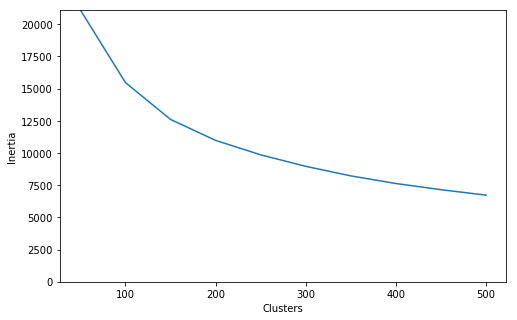

In [128]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(50, 501, 50)), inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.ylim(0, inertia[0])
plt.show()

In [129]:
kmeans = KMeans(n_clusters = 300, random_state=30).fit(doc_vecs)
categories = kmeans.cluster_centers_

In [130]:
categories.shape

(300, 10)

In [132]:
type(categories)

numpy.ndarray

In [131]:
for i,topic in enumerate(categories):
    print(f"Topic {i}")
    print([j[0] for j in closest_topic(model, topic)])

Topic 0
['moorcroft', 'fv', 'forward-', 'xr-100r', 'disproven']
Topic 1
['tolerating', 'zhen', 'symmetrical', 'hesitation', 'tsimbinos']
Topic 2
['refers', 'epistle', 'circumcision', 'theory_', 'shatim']
Topic 3
['processing', 'enhancement', 'complement', 'imaging', 'teledisk']
Topic 4
['karina', 'mamma', 'clothes', 'marina', 'stomping']
Topic 5
['cryptosystem', 'factoring', 'public-key', 'single-click', 'hash']
Topic 6
['aggression', 'cyprus', 'turkish', 'karabakh', 'troop']
Topic 7
['imake', 'diffs', 'r5', 'vtwm', 'r4']
Topic 8
['darkhawk', 'mcfarlane', 'hulk', 'unpunched', 'mutant']
Topic 9
['sleight', 'metaphase', 'cheney', 'percival', 'bcarm41a']
Topic 10
['multistate', 'construction', 'recruited', 'tubal', 'hus']
Topic 11
['malakhov', 'oates', 'courtnall', 'juneau', 'nedved']
Topic 12
['posibility', 'ness', 'land-mobile', 'crackable', 'befalling']
Topic 13
['nb8f', 's0g-', 't-', 't\\', 'm7']
Topic 14
['batting', 'defenition', 'pitched', 'bullpen', 'platoon']
Topic 15
['spray', 'r

['reprogrammed', 'monopoly', 'invest', 'dime', 'n4tmi']
Topic 233
['x386', 'xfree86', 'developer', 'special-purpose', 'sparc']
Topic 234
['obedient', "we're-", 'preaching', 'merciful', 'shun']
Topic 235
['preamp', 'hydrolic', 'racet', 'low-speed', 'thd']
Topic 236
['diet', 'candida', 'bloom', 'anti-gay', 'fungus']
Topic 237
['spackle', 'semi-auto', 'glocks', 'gaia', 'marksmanship']
Topic 238
['clinical', 'nejm', 'hiv', 'survey', 'high-risk']
Topic 239
['privileged', 'capitalism', 'withstand', 'intrest', 'productive']
Topic 240
['empirical', 'lysenko', 'methodology', 'phobia', 'extra-rational']
Topic 241
['non-licensed', 'multi-lingual', 'nowadys', 'wrap', 'sample']
Topic 242
['unixware', 'amiga', 'watkinson', 'glx', 'gfxbase']
Topic 243
['peaceably', 'twit', 'briefcase', 'roby', 'willson']
Topic 244
['archiving', 'escrow', 'secure', 'encryption', 'encrypt']
Topic 245
['skibum7', 'comic', 'dragon', 'unpunched', 'excellent']
Topic 246
['assist', 'orbit', 'field', 'martian', 'asteroid']
T

In [136]:
# persisting model and resources

np.save('topic_vectors.npy', categories)
model.save('doc2vec_model')

## TF-IDF Vectorization

In [49]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=5, 
                                   max_features=2000, stop_words='english', 
                                   ngram_range=(1, 2))

tfidf = tfidf_vectorizer.fit_transform(corpus)

## Modeling Investigation

In [52]:
n_features = 2000
n_components = 6
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

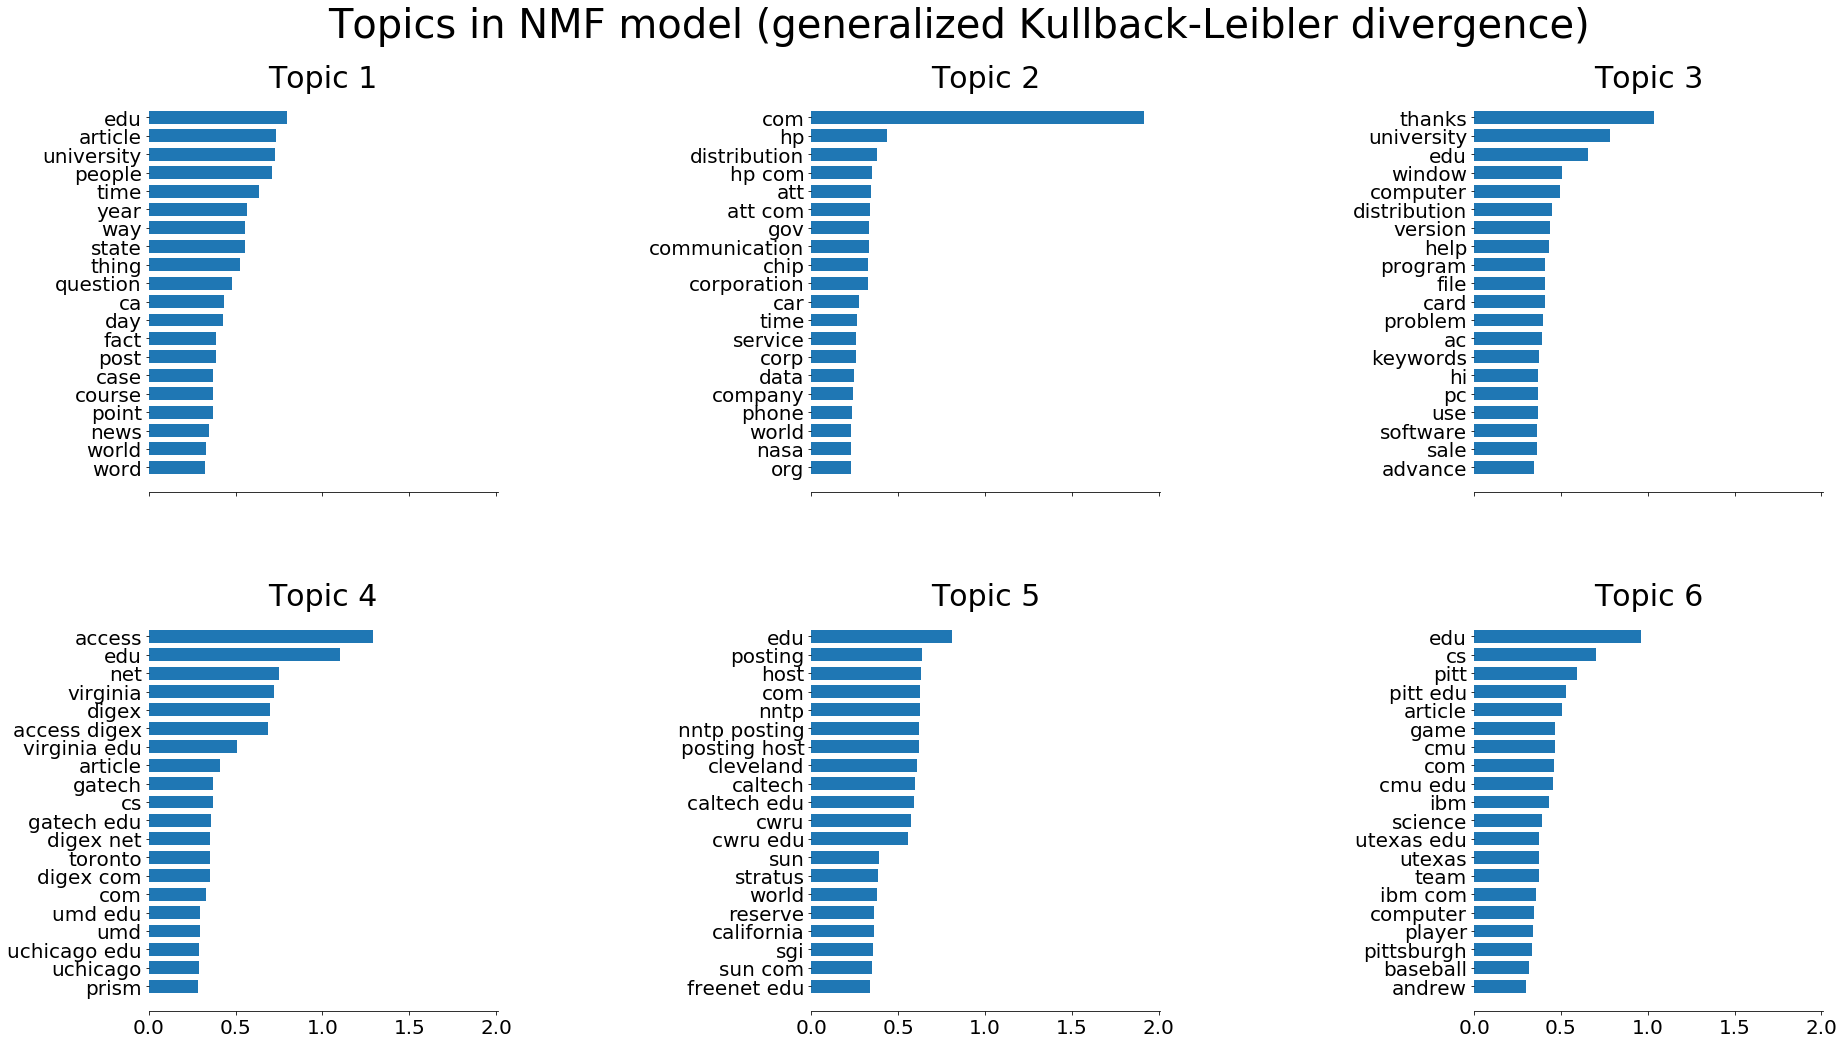

In [53]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=100000,
    alpha=0.1,
    l1_ratio=0.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (generalized Kullback-Leibler divergence)"
)

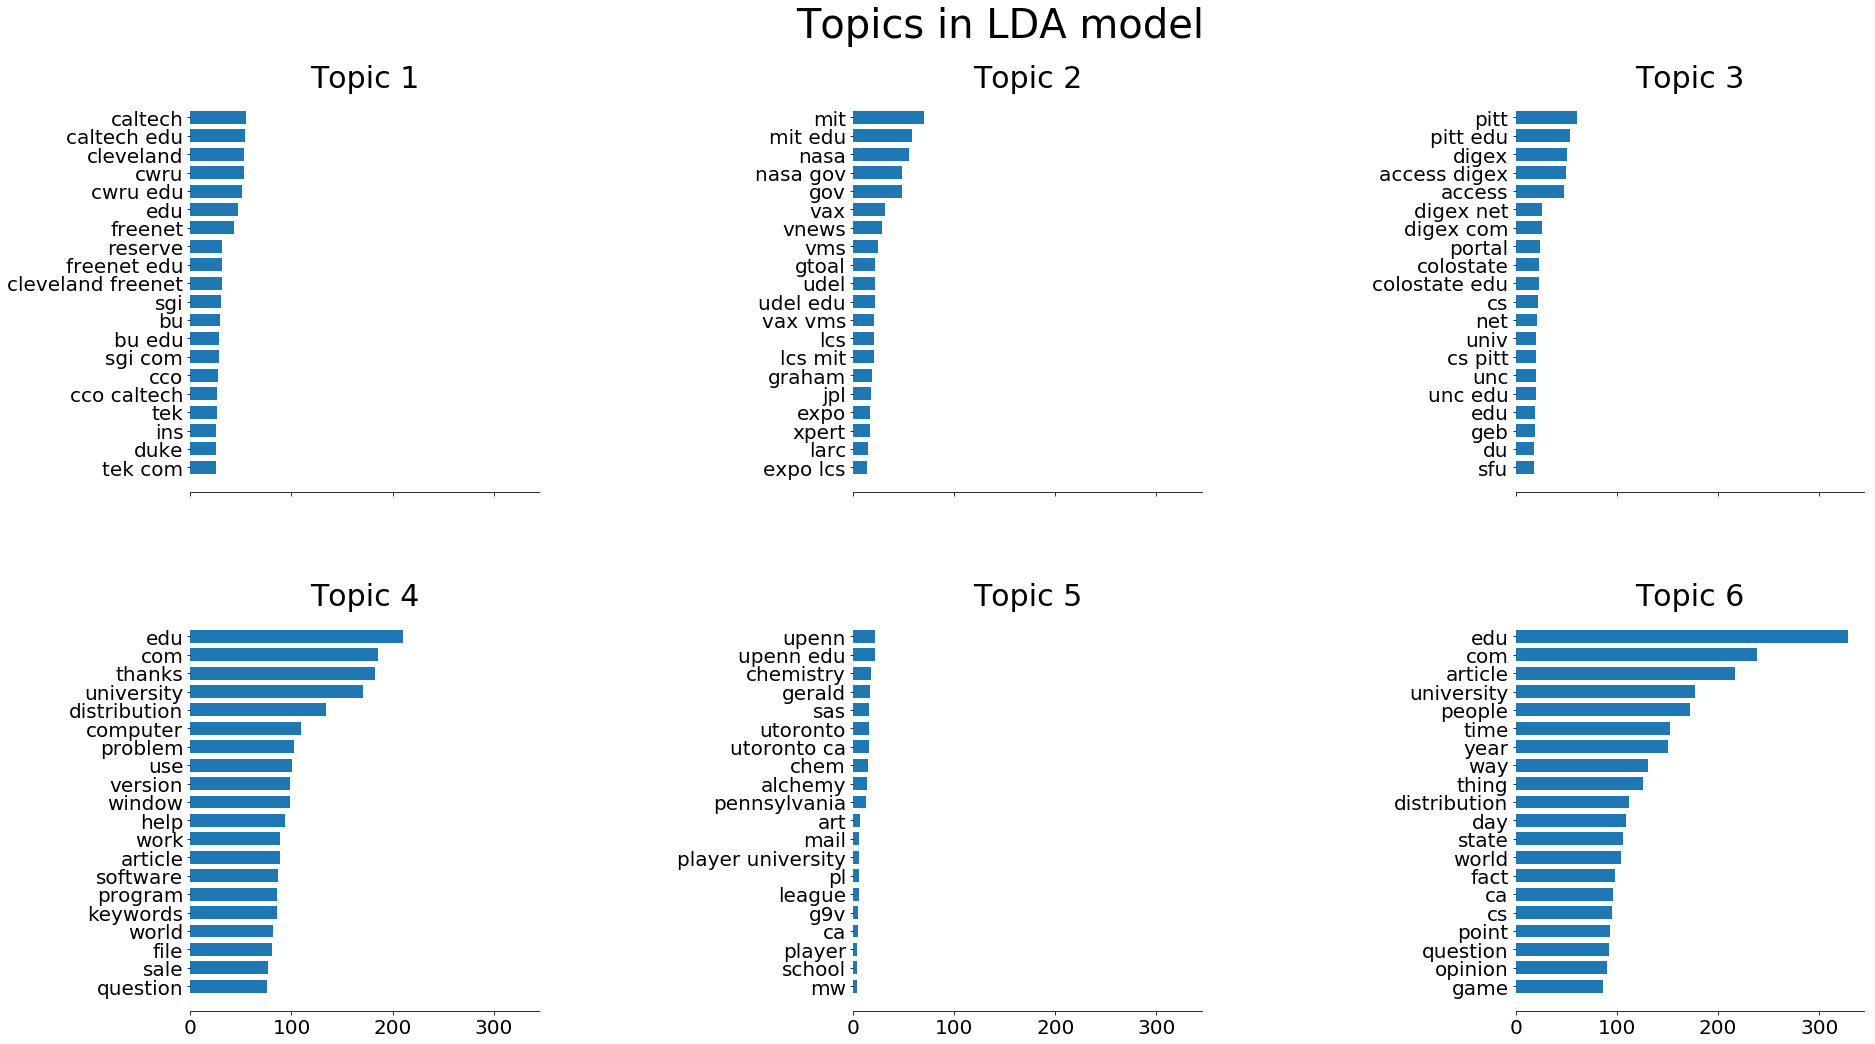

In [54]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=50,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(tfidf)

tf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")